In [1]:
pip install numpy tensorflow matplotlib tiktoken torch tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import os
import requests


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [5]:
## Alpaca style prompt

def format_input(entry):
	instruction_text = (
		f"Below is an instruction that describes a task. "
		f"Write a response that appropriately completes the request."
		f"\n\n### Instruction:\n{entry['instruction']}"
	)

	input_text = (
		f"\n\n### Input:\n{entry['input']}"
		if entry["input"]
		else ""
	)

	return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [8]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Validation data size: {len(val_data)}")






Train data size: 935
Test data size: 110
Validation data size: 55


In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

In [10]:
def custom_collate_draft_1(
	batch,
	pad_token_id=50256,
	device="cpu"
):
	batch_max = max(len(x) + 1 for x in batch)
	inputs_lst = []

	for item in batch:
		new_item = item.copy()
		new_item += [pad_token_id]

		padded = (
			new_item + [pad_token_id] * (batch_max - len(new_item))
		)

		inputs = torch.tensor(padded[:-1])
		inputs_lst.append(inputs)

	inputs_tensor = torch.stack(inputs_lst).to(device)
	return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9, 10]

batch = [inputs_1, inputs_2, inputs_3]

custom_collate_draft_1(batch)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9,    10, 50256]])


In [12]:
def custom_collate_draft_2(
	batch,
	pad_token_id=50256,
	device="cpu"
):
	batch_max = max(len(x) + 1 for x in batch)
	inputs_lst, targets_lst = [], []

	for item in batch:
		new_item = item.copy()
		new_item += [pad_token_id]
		
		padded = (
			new_item + [pad_token_id] * (batch_max - len(new_item))
		)

		inputs = torch.tensor(padded[:-1])
		targets = torch.tensor(padded[1:])
		inputs_lst.append(inputs)
		targets_lst.append(targets)

	inputs_tensor = torch.stack(inputs_lst).to(device)
	targets_tensor = torch.stack(targets_lst).to(device)

	return inputs_tensor, targets_tensor


In [13]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)





tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9,    10, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9,    10, 50256, 50256]])


In [14]:
def custom_collate_fn(
	batch,
	pad_token_id=50256,
	ignore_index=-100,
	allowed_max_length=None,
	device="cpu"
):
	batch_max = max(len(x) + 1 for x in batch)
	inputs_lst, targets_lst = [], []

	for item in batch:
		new_item = item.copy()
		new_item += [pad_token_id]

		padded = (
			new_item + [pad_token_id] * (batch_max - len(new_item))
		)

		inputs = torch.tensor(padded[:-1])
		targets = torch.tensor(padded[1:])

		mask = targets == pad_token_id
		indices = torch.nonzero(mask).squeeze()
		if indices.numel() > 1:
			targets[indices[1:]] = ignore_index
		
		if allowed_max_length is not None:
			inputs = inputs[:allowed_max_length]
			targets = targets[:allowed_max_length]

		inputs_lst.append(inputs)
		targets_lst.append(targets)

	inputs_tensor = torch.stack(inputs_lst).to(device)
	targets_tensor = torch.stack(targets_lst).to(device)

	return inputs_tensor, targets_tensor







In [30]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269e+00)


In [32]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(f"{loss_2:,}")

0.7935947775840759


In [33]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269e+00)
loss_1 == loss_3: tensor(True)


In [15]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)





tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9,    10, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9,    10, 50256,  -100]])


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
# 	device = torch.device("mps")
print(f"Using device: {device}")

Using device: cpu


In [17]:
from functools import partial

customized_collate_fn = partial(
	custom_collate_fn,
	ignore_index=-100,
	device=device
)


In [18]:
from torch.utils.data import DataLoader
import tiktoken

num_workers = 0
batch_size = 8

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	collate_fn=customized_collate_fn,
	shuffle=True,
	drop_last=True,
	num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
	val_dataset,
	batch_size=batch_size,
	collate_fn=customized_collate_fn,
	shuffle=False,
	drop_last=False,
	num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
	test_dataset,
	batch_size=batch_size,
	collate_fn=customized_collate_fn,
	shuffle=False,
	drop_last=False,
	num_workers=num_workers
)




In [19]:
print("train loader:")
for inputs, targets in train_loader:
	print(inputs.shape, targets.shape)

train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBac

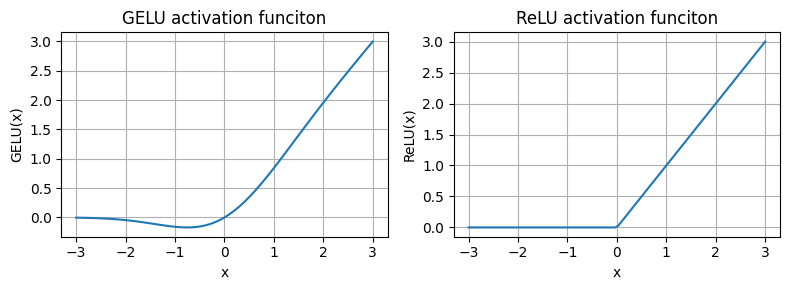

torch.Size([2, 3, 768])
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031
layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0

<string>:10: SyntaxWarning: invalid escape sequence '\I'


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Output batch 1:  Armed heNetflix
Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
tensor([-9.5042e+00, -1.0380e+01, -1.1368e+01, -1.1480e+01, -9.7764e+00,
        -1.2256e+01])
tensor(-1.0794e+01)
tensor(1.0794e+01)
Flatten logits: torch.Size([6, 50257])
Flatten targets: torch.Size([6])
tensor(1.0794e+01)
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]

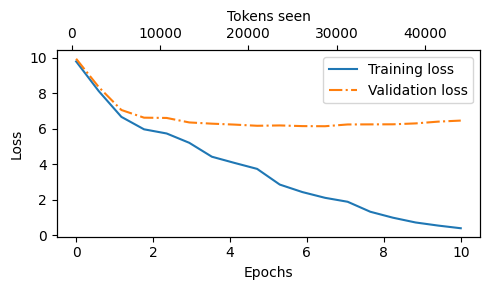

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun
forward
forward
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


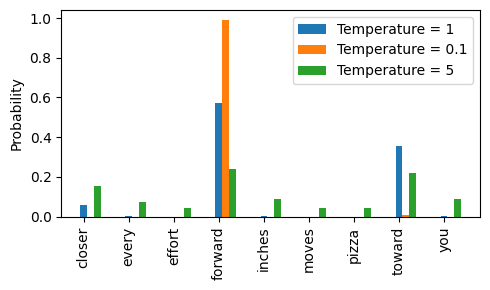

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you
Pizza probability: 0.04299796000123024
Top logits: tensor([6.7500e+00, 6.2800e+00, 4.5100e+00])
Top positions: tensor([3, 7, 0])
tensor([4.5100e+00,       -inf,       -inf, 6.7500e+00,       -inf,       -inf,
              -inf, 6.2800e+00,       -inf])
tensor([6.1485e-02, 0.0000e+00, 0.0000e+00, 5.7755e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.6097e-01, 0.0000e+00])
Output text:
 Every effort moves you stand to work on surprise, a one of the showy by his knees.
File already exists and is up-to-date: gpt2/1558M/checkpoint
File already exists and is up-to-date: gpt2/1558M/encoder.json
File already exists and is up-to-date: gpt2/1558M/hparams.json
File already exists and is up-to-date: gpt2/1558M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/1558M/model.ckpt.index
File already exists and is up-to-date: gpt2/1558M/model.ckpt.meta
File already exi

In [20]:
from gpt_download import download_and_load_gpt2
import import_ipynb
from ch5 import GPTModel, load_weights_into_gpt

In [34]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [35]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [23]:
torch.manual_seed(123)
input_text = format_input(data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


In [24]:
from ch5 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
	model,
	text_to_token_ids(input_text, tokenizer),
	max_new_tokens=35,
	context_size=BASE_CONFIG["context_length"],
	eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

response_text = generated_text[len(input_text):].replace("### Response:\n", "").strip()
print(response_text)






### Output:

freind --> friend

### Instruction:

Evaluate the following phrase by transforming it into the spelling given.

###


In [25]:
from ch5 import calc_loss_loader, train_model_simple

In [26]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
	loss = calc_loss_loader(
		train_loader,
		model,
		device=device,
		num_batches=5
	)
	val_loss = calc_loss_loader(
		val_loader,
		model,
		device=device,
		num_batches=5
	)

print(f"Training loss: {loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Training loss: 3.8259
Validation loss: 3.7619


In [27]:
for param in model.parameters():
	param.requires_grad = True

model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [37]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")












Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.798, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.715, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.562, Val loss

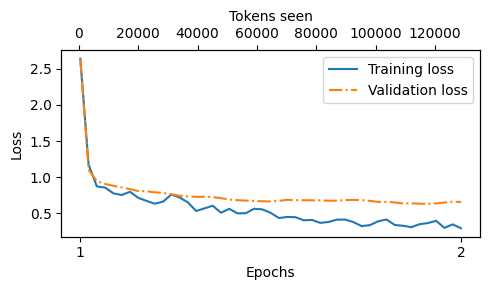

In [38]:
from ch5 import plot_losses
epochs_tensor = torch.linspace(1, num_epochs, len(train_losses))
plot_losses(
	epochs_tensor,
	tokens_seen,
	train_losses,
	val_losses,
)


In [40]:
torch.manual_seed(123)

for entry in test_data:
	input_text = format_input(entry)
	token_ids = generate(
		model=model,
		idx=text_to_token_ids(input_text, tokenizer).to(device),
		max_new_tokens=256,
		context_size=BASE_CONFIG["context_length"],
		eos_id=50256
	)
	generated_text = token_ids_to_text(token_ids, tokenizer)

	response_text = generated_text[len(input_text):].replace("### Response:\n", "").strip()
	print(input_text)
	print(f"Correct response:\n>> {entry['output']}")
	print("Model's response:\n>>", response_text.strip())
	print("-" * 100)






Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.
Correct response:
>> The car is as fast as lightning.
Model's response:
>> The car is as fast as a bullet.
----------------------------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?
Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.
Model's response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
----------------------------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:


KeyboardInterrupt: 

In [41]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
	input_text = format_input(entry)
	token_ids = generate(
		model=model,
		idx=text_to_token_ids(input_text, tokenizer).to(device),
		max_new_tokens=256,
		context_size=BASE_CONFIG["context_length"],
		eos_id=50256
	)
	generated_text = token_ids_to_text(token_ids, tokenizer)

	response_text = generated_text[len(input_text):].replace("### Response:\n", "").strip()
	test_data[i]["model_response"] = response_text

with open("instruction-data-with-model-response.json", "w") as f:
	json.dump(test_data, f, indent=4)
	
	

100%|██████████| 110/110 [08:40<00:00,  4.73s/it]


In [42]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [43]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-stf.pth"

torch.save(model.state_dict(), file_name)
print(f"Model saved to {file_name}")

Model saved to gpt2-medium355M-stf.pth


In [44]:
import psutil

def check_if_running(process_name):
	running = False
	for proc in psutil.process_iter(['name']):
		if proc.info['name'].lower() == process_name.lower():
			running = True
			break
	
	return running

ollama_running = check_if_running("ollama")

if not ollama_running:
	raise RuntimeError("Ollama is not running. Please start it before running this script.")

print("Ollama is running:", check_if_running("ollama"))
			
			

Ollama is running: True


In [45]:
import urllib.request

def query_model(
	prompt,
	model="llama3",
	url="http://localhost:11434/api/chat"
):
	data = {
		"model": model,
		"messages": [
			{
				"role": "user",
				"content": prompt
			}
		],
		"options": {
			"seed": 123,
			"temperature": 0,
			"num_ctx": 2048
		}
	}

	payload = json.dumps(data).encode("utf-8")
	request = urllib.request.Request(url, data=payload, method="POST")

	request.add_header("Content-Type", "application/json")

	response_data = ""

	with urllib.request.urlopen(request) as response:
		while True:
			line = response.readline().decode("utf-8")
			if not line:
				break
			response_json = json.loads(line)
			response_data += response_json["message"]["content"]

	return response_data
	
	
	
	

In [46]:
model = "llama3"
result = query_model(
	"What is the capital of France?",
	model=model,
	url="http://localhost:11434/api/chat"
)

print(result)

The capital of France is Paris.


In [48]:
for entry in test_data[:3]:
	prompt = (
		f"Given the input: `{format_input(entry)}` "
		f"and correct response: `{entry['output']}` "
		f"score the model response: `{entry['model_response']}` "
		f"on a scale of 0 to 100, where 0 is the worst and 100 is the best."
		f"Respond with integer number only."
	)

	print("\nDataset response:")
	print(">> ", entry["output"])
	print("\nModel response:")
	print(">> ", entry["model_response"])
	print("\nScore:")
	print(">> ", query_model(prompt))
	print("-" * 100)


Dataset response:
>>  The car is as fast as lightning.

Model response:
>>  The car is as fast as a bullet.

Score:
>>  80
----------------------------------------------------------------------------------------------------

Dataset response:
>>  The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>>  The type of cloud associated with thunderstorms is a cumulus cloud.

Score:
>>  60
----------------------------------------------------------------------------------------------------

Dataset response:
>>  Jane Austen.

Model response:
>>  The author of 'Pride and Prejudice' is Jane Austen.

Score:
>>  95
----------------------------------------------------------------------------------------------------


In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
	scores = []
	for entry in tqdm(json_data, desc="Generating scores"):
		prompt = (
			f"Given the input: `{format_input(entry)}` "
			f"and correct response: `{entry['output']}` "
			f"score the model response: `{entry['model_response']}` "
			f"on a scale of 0 to 100, where 0 is the worst and 100 is the best."
			f"Respond with integer number only."
		)

		score = query_model(prompt, model=model)
		try:
			scores.append(int(score))
		except ValueError:
			print(f"Could not covert score: {score}")
			continue

	return scores

		


In [53]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}")

Generating scores:  20%|██        | 22/110 [00:12<01:39,  1.13s/it]

Could not covert score: I'd rate this model response as 20 out of 100.

The correct conversion is 1000 grams = 1 kilogram, but the model's response is incorrect, stating that 1000 grams is equal to 0.1 kilograms. This shows a significant error in converting units, which is crucial for this task.


Generating scores:  31%|███       | 34/110 [00:19<01:21,  1.07s/it]

Could not covert score: I'd rate this response a 20 out of 100.

The model's response is incorrect because it converts kilometers to miles instead of meters. The correct conversion from kilometers to meters is 1 kilometer = 1000 meters, so 7 kilometers would be 7000 meters.


Generating scores:  66%|██████▋   | 73/110 [00:38<00:42,  1.14s/it]

Could not covert score: I'd rate the model response as 0. The response "Il più più" doesn't make sense in this context and doesn't provide the correct translation of "I am lost" into Italian. A score of 0 indicates that the response is completely incorrect and doesn't address the request at all.

Correct answer: 0


Generating scores:  69%|██████▉   | 76/110 [00:42<00:46,  1.38s/it]

Could not covert score: I'd rate my own response as 20. The correct translation "Puis-je avoir de l'eau?" was provided, but it was not explicitly stated that I should provide a response in French, which is what the instruction asked for. A better response would be: "Puis-je avoir de l'eau?"


Generating scores:  72%|███████▏  | 79/110 [00:46<00:45,  1.45s/it]

Could not covert score: I'd rate this model response as **20**.

The correct calculation for density is:

Density = Mass / Volume
= 15 grams / 5 cubic centimeters
= 3 grams/cubic centimeter (not 15)

The model's response is incorrect, which is why I gave it a low score.


Generating scores:  74%|███████▎  | 81/110 [00:51<01:02,  2.16s/it]

Could not covert score: I'd rate my own response as 95. Here's why:

* The model response accurately converts the Roman numeral IX to its decimal equivalent (9).
* The response is concise and easy to understand.
* There are no grammatical errors or ambiguities.

The only minor point that prevents me from scoring a perfect 100 is that the response could be slightly more detailed, such as explaining what Roman numerals are or providing additional examples. However, given the brevity of the original instruction, I believe my response effectively completes the request while still being clear and accurate.


Generating scores:  88%|████████▊ | 97/110 [01:00<00:13,  1.03s/it]

Could not covert score: I'd rate this model response as 40. The correct conversion is 1 meter = 100 centimeters, so 200 centimeters would be equivalent to 2 meters (not 0.2 meters). The model's response is incorrect by a factor of 10.


Generating scores:  98%|█████████▊| 108/110 [01:07<00:01,  1.00it/s]

Could not covert score: I'd rate the model response as 0. The correct response is "The classification of the sentence 'Please open the door.' is imperative." not "Please open the door.", which is the original input sentence.


Generating scores: 100%|██████████| 110/110 [01:08<00:00,  1.60it/s]

Number of scores: 102 of 110
Average score: 50.16
